# Práctico 3 - Astrometría
## Análisis de datos de galaxias

In [50]:
# LIBRERIAS A USAR Y CARGA DE DATOS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy.optimize as opt


sns.set_palette("Accent") 
# Cargo los archivos y descarto las galaxias con blueshift
df0 = pd.read_csv('/mnt/sda2/astrometria/practico_3/P3_shulypuddu.csv')
df = df0[(df0['z'] > 0) & (df0['z'] < 0.3) &((df0['u']-df0['r']) > 0.25) & ((df0['u']-df0['r']) < 4.5)]

# Separo en rojas y azules
rojo = df[(df['u']-df['r'])>2.5]
azul = df[(df['u']-df['r'])<2.5]
color_r = '#cd5c5c' #indianred
color_a = '#4169e1' #royalblue

# Separo en elipticas y espirales usando ZOOVOTES
elip = df[df['elip']>0.8]
esp = df[df['esp']>0.8]
mer = df[df['meg']>0.8]

# Separo en bulge y disco usando fracDeV_r
bulge = df[df['fracDeV_r']>0.8]
disco = df[df['fracDeV_r']<0.2]

ur = (df['u']-df['r']).dropna()
gr = (df['g']-df['r']).dropna()
ug = (df['u']-df['g']).dropna()

In [37]:
# AJUSTE LINEAL CASERO
def cuad_min(x, y):
    """
    --Parámetros--
    x, y : pandas Series o arrays 
    --Retorna--
    Los coeficientes a y b de la recta y = ax + b
    """
    _x = x.values  # Convertir a numpy array
    _y = y.values 
    
    # Calcular medias
    x_medio = np.mean(_x)
    y_medio = np.mean(_y)
    
    # Calcular diferencias (como arrays, no listas)
    delta_x = _x - x_medio
    delta_y = _y - y_medio
    
    # Fórmulas de mínimos cuadrados
    a = np.sum(delta_x * delta_y) / np.sum(delta_x**2)
    b = y_medio - a * x_medio
    
    return a, b

# Calculo la recta
muestra = df.sample(frac=0.05, random_state=252)
a, b = cuad_min(muestra['g'], muestra['r'])
y = a * muestra['g'] + b

# AJUSTE DOBLE GAUSSIANA

def doble_gaussiana(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    return (amp1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2)) +
            amp2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2)))

def gauss(x,amp,mu,sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

chi=[]
cuentas, bordes = np.histogram(ur, bins=50,density=True)
centros = (bordes[:-1] + bordes[1:]) / 2

# Estimaciones iniciales para los parámetros
p0 = [1, ur.mean()-0.5, ur.std()/2, 1,ur.mean()+0.5, ur.std()/2]

# Ajuste
params, cov = opt.curve_fit(doble_gaussiana, centros, cuentas, p0=p0)

x_fit = np.linspace(ur.min(), ur.max(), 200)
x1_fit = np.linspace(ur.min(), 3, 200)
x2_fit = np.linspace( 1,ur.max(), 200)
g_azul= gauss(x1_fit,params[0],params[1],params[2])
g_rojo= gauss(x2_fit,params[3],params[4],params[5])

def diferencia(x):
    return gauss(x,params[0],params[1],params[2]) - gauss(x,params[3],params[4],params[5])
x_inicial= (params[4]+params[1])/2
x_cruce = opt.fsolve(diferencia, x_inicial)[0]

 TEST CHI-CUADRADO PARA BONDAD DE AJUSTE:
   Chi² = 362.7095, Chi critico = 66.3386 
   p-value = 0.0000
   Grados de libertad = 49
Usando como test estadístico al valor de p
   RESULTADO: Rechazamos H₀ - El ajuste NO es bueno
Usando como test estadístico al chi²
   RESULTADO: Rechazamos H₀ - El ajuste NO es bueno


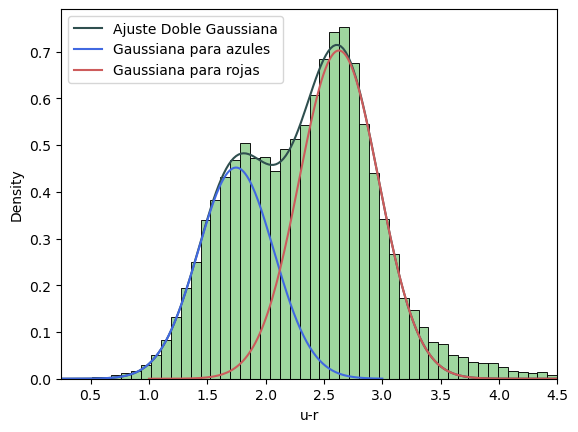

In [38]:
# PRIMEROS GRÁFICOS

gl = 49  # cantidad de bines -1  
chi_c = st.chi2.ppf((1-0.05), gl)
p_c = 0.05

# Usar los centros del histograma para ambos
observadas = cuentas  # frecuencias observadas del histograma
esperadas = doble_gaussiana(centros, *params)  # frecuencias esperadas del ajuste

# Normalizar para que las sumas coincidan (importante para el test)
esperadas = esperadas * np.sum(observadas) / np.sum(esperadas)

chi2, p_value1 = st.chisquare(observadas, esperadas)

print(" TEST CHI-CUADRADO PARA BONDAD DE AJUSTE:")
print(f"   Chi² = {chi2:.4f}, Chi critico = {chi_c:.4f} ")
print(f"   p-value = {p_value1:.4f}")
print(f"   Grados de libertad = {gl}")
print('Usando como test estadístico al valor de p')
if p_value1 < p_c:
    print("   RESULTADO: Rechazamos H₀ - El ajuste NO es bueno")
else:
    print("   RESULTADO: No rechazamos H₀ - El ajuste es aceptable")
print('Usando como test estadístico al chi²')
if chi2 >= chi_c:
    print("   RESULTADO: Rechazamos H₀ - El ajuste NO es bueno")
else:
    print("   RESULTADO: No rechazamos H₀ - El ajuste es aceptable")

sns.histplot((df['u']-df['r']),bins=50,alpha=0.75,stat='density')
plt.plot(x_fit, doble_gaussiana(x_fit, *params), label='Ajuste Doble Gaussiana', color='darkslategray')
plt.plot(x1_fit, g_azul,  label='Gaussiana para azules',color=color_a) 
plt.plot(x2_fit, g_rojo, color=color_r, label='Gaussiana para rojas') 
plt.xlim(0.25,4.5)
plt.xlabel('u-r')
plt.legend()
plt.savefig('/mnt/sda2/astrometria/practico_3/informe/imagenes/ur.pdf',dpi=300,bbox_inches='tight')
plt.show()

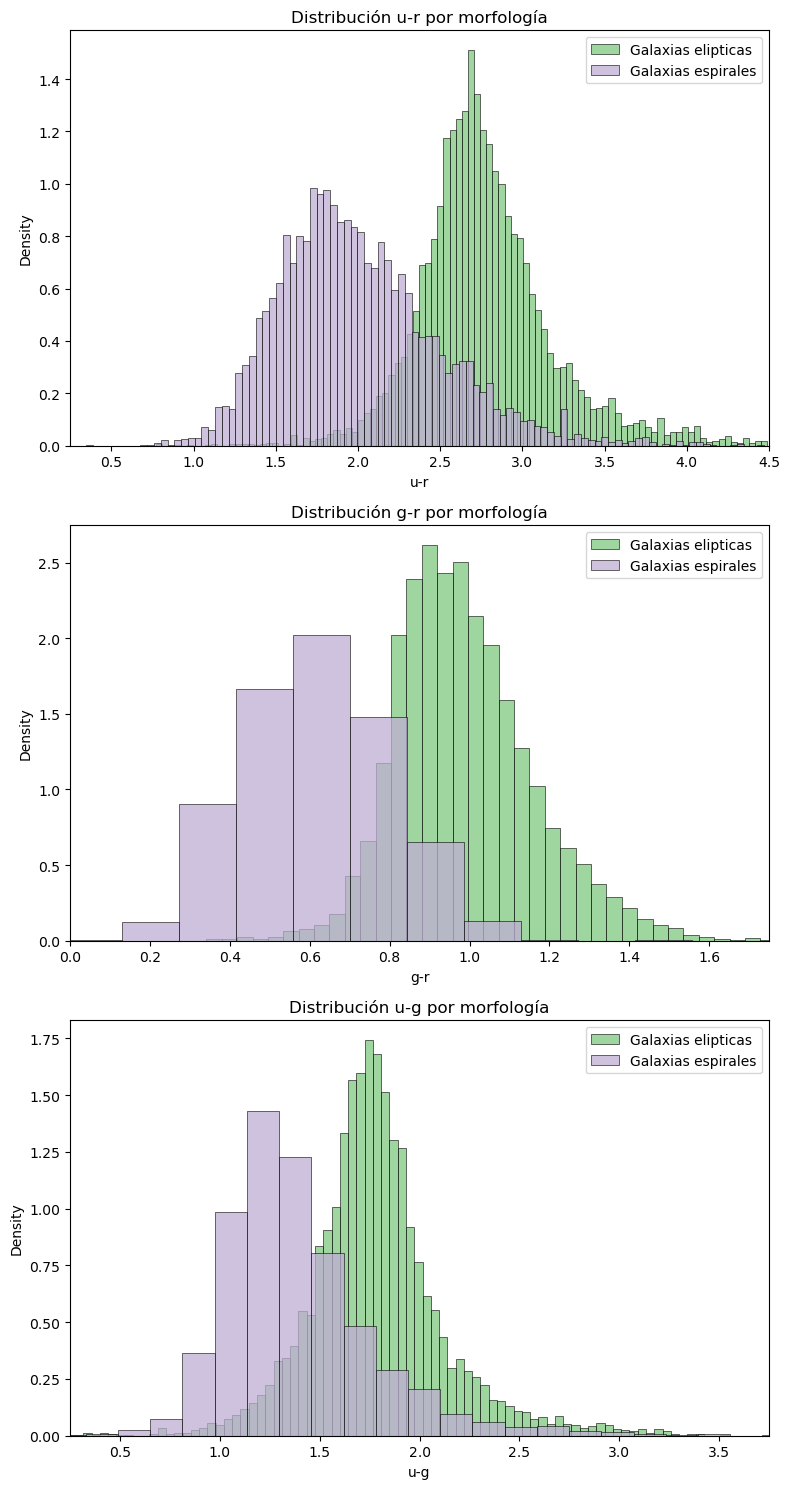

In [39]:
# ELIPTICAS Y ESPIRALES

fig, axes = plt.subplots(3, 1, figsize=(8, 15))

# Primer subplot - u-r
sns.histplot((elip['u']- elip['r']),bins=100,alpha=0.75,stat='density', label='Galaxias elipticas', ax=axes[0])
sns.histplot((esp['u']- esp['r']),bins=100,alpha=0.75,stat='density',label='Galaxias espirales', ax=axes[0])
axes[0].set_xlim(0.25,4.5)
axes[0].set_xlabel('u-r')
axes[0].legend()
axes[0].set_title('Distribución u-r por morfología')

# Segundo subplot - g-r
sns.histplot((elip['g']- elip['r']),bins=100,alpha=0.75,stat='density', label='Galaxias elipticas', ax=axes[1])
sns.histplot((esp['g']- esp['r']),bins=100,alpha=0.75,stat='density', label='Galaxias espirales', ax=axes[1])
axes[1].set_xlim(0,1.75)
axes[1].set_xlabel('g-r')
axes[1].legend()
axes[1].set_title('Distribución g-r por morfología')

# Tercer subplot - u-g
sns.histplot((elip['u']-elip['g']),bins=100,alpha=0.75,stat='density', label='Galaxias elipticas', ax=axes[2])
sns.histplot((esp['u']-esp['g']),bins=100,alpha=0.75,stat='density', label='Galaxias espirales', ax=axes[2])
axes[2].set_xlim(0.25,3.75)
axes[2].set_xlabel('u-g')
axes[2].legend()
axes[2].set_title('Distribución u-g por morfología')

plt.tight_layout()
plt.savefig('/mnt/sda2/astrometria/practico_3/informe/imagenes/colores_morfologia_vertical.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [40]:
#---------- TEST CHI-CUADRADO PARA u-r entre Elípticas y Espirales --------------------------------

print("TEST CHI-CUADRADO PARA u-r entre Elípticas y Espirales:")

# Calcular histogramas con los mismos bines
cuentas_elip, bordes_ur = np.histogram(elip['u'] - elip['r'], bins=50, range=(0.25, 4.5))
cuentas_esp, _ = np.histogram(esp['u'] - esp['r'], bins=50, range=(0.25, 4.5))

observadas = cuentas_elip + 1 # Añadir 1 para evitar ceros
esperadas = cuentas_esp + 1 # Añadir 1 para evitar ceros

esperadas = esperadas * np.sum(observadas) / np.sum(esperadas)


chi2_ur, p_value_ur = st.chisquare(observadas, esperadas)

grados_libertad_ur = len(observadas) - 1 # Bines - 1
chi_critico_ur = st.chi2.ppf((1-0.05), grados_libertad_ur)

print(f"   Chi² = {chi2_ur:.4f}, Chi critico = {chi_critico_ur:.4f} ")
print(f"   p-value = {p_value_ur:.4f}")
print(f"   Grados de libertad = {grados_libertad_ur}")
print('Usando como test estadístico al valor de p')
if p_value_ur < 0.05:
    print("   RESULTADO: Rechazamos H₀ - Las distribuciones de u-r son significativamente diferentes")
else:
    print("   RESULTADO: No rechazamos H₀ - No hay evidencia suficiente para decir que las distribuciones de u-r son diferentes")
print('Usando como test estadístico al chi²')
if chi2_ur >= chi_critico_ur:
    print("   RESULTADO: Rechazamos H₀ - Las distribuciones de u-r son significativamente diferentes")
else:
    print("   RESULTADO: No rechazamos H₀ - No hay evidencia suficiente para decir que las distribuciones de u-r son diferentes")

TEST CHI-CUADRADO PARA u-r entre Elípticas y Espirales:
   Chi² = 42718.9396, Chi critico = 66.3386 
   p-value = 0.0000
   Grados de libertad = 49
Usando como test estadístico al valor de p
   RESULTADO: Rechazamos H₀ - Las distribuciones de u-r son significativamente diferentes
Usando como test estadístico al chi²
   RESULTADO: Rechazamos H₀ - Las distribuciones de u-r son significativamente diferentes


In [41]:
#---------- TEST CHI-CUADRADO PARA u-r entre Elípticas y Espirales --------------------------------

print("TEST CHI-CUADRADO PARA u-r entre Elípticas y Espirales:")

# Calcular histogramas con los mismos bines
cuentas_elip, bordes_ur = np.histogram(elip['g'] - elip['r'], bins=50, range=(0.25, 4.5))
cuentas_esp, _ = np.histogram(esp['g'] - esp['r'], bins=50, range=(0.25, 4.5))

observadas = cuentas_elip + 1 # Añadir 1 para evitar ceros
esperadas = cuentas_esp + 1 # Añadir 1 para evitar ceros

esperadas = esperadas * np.sum(observadas) / np.sum(esperadas)

chi2_ur, p_value_ur = st.chisquare(observadas, esperadas)

grados_libertad_ur = len(observadas) - 1 # Bines - 1
chi_critico_ur = st.chi2.ppf((1-0.05), grados_libertad_ur)

print(f"   Chi² = {chi2_ur:.4f}, Chi critico = {chi_critico_ur:.4f} ")
print(f"   p-value = {p_value_ur:.4f}")
print(f"   Grados de libertad = {grados_libertad_ur}")
print('Usando como test estadístico al valor de p')
if p_value_ur < 0.05:
    print("   RESULTADO: Rechazamos H₀ - Las distribuciones de u-r son significativamente diferentes")
else:
    print("   RESULTADO: No rechazamos H₀ - No hay evidencia suficiente para decir que las distribuciones de u-r son diferentes")
print('Usando como test estadístico al chi²')
if chi2_ur >= chi_critico_ur:
    print("   RESULTADO: Rechazamos H₀ - Las distribuciones de u-r son significativamente diferentes")
else:
    print("   RESULTADO: No rechazamos H₀ - No hay evidencia suficiente para decir que las distribuciones de u-r son diferentes")

TEST CHI-CUADRADO PARA u-r entre Elípticas y Espirales:
   Chi² = 278614.0106, Chi critico = 66.3386 
   p-value = 0.0000
   Grados de libertad = 49
Usando como test estadístico al valor de p
   RESULTADO: Rechazamos H₀ - Las distribuciones de u-r son significativamente diferentes
Usando como test estadístico al chi²
   RESULTADO: Rechazamos H₀ - Las distribuciones de u-r son significativamente diferentes


In [42]:
#---------- TEST CHI-CUADRADO PARA u-r entre Elípticas y Espirales --------------------------------

print("TEST CHI-CUADRADO PARA u-r entre Elípticas y Espirales:")

# Calcular histogramas con los mismos bines
cuentas_elip, bordes_ur = np.histogram(elip['u'] - elip['g'], bins=50, range=(0.25, 4.5))
cuentas_esp, _ = np.histogram(esp['u'] - esp['g'], bins=50, range=(0.25, 4.5))

# Asegurarse de que no haya bines con cero o muy pocas cuentas (puede causar problemas en chi-cuadrado)
# Combinar bines si es necesario, o usar un método alternativo si hay muchos bines vacíos.
# Para este ejemplo simple, sumaremos 1 a cada bin para evitar ceros, aunque no es la mejor práctica general.
# Una mejor práctica sería agrupar bines con pocas observaciones.
observadas = cuentas_elip + 1 # Añadir 1 para evitar ceros
esperadas = cuentas_esp + 1 # Añadir 1 para evitar ceros

# Normalize the expected frequencies to match the sum of observed frequencies
esperadas = esperadas * np.sum(observadas) / np.sum(esperadas)


# Realizar el test de chi-cuadrado
chi2_ur, p_value_ur = st.chisquare(observadas, esperadas)

grados_libertad_ur = len(observadas) - 1 # Bines - 1
chi_critico_ur = st.chi2.ppf((1-0.05), grados_libertad_ur)

print(f"   Chi² = {chi2_ur:.4f}, Chi critico = {chi_critico_ur:.4f} ")
print(f"   p-value = {p_value_ur:.4f}")
print(f"   Grados de libertad = {grados_libertad_ur}")
print('Usando como test estadístico al valor de p')
if p_value_ur < 0.05:
    print("   RESULTADO: Rechazamos H₀ - Las distribuciones de u-r son significativamente diferentes")
else:
    print("   RESULTADO: No rechazamos H₀ - No hay evidencia suficiente para decir que las distribuciones de u-r son diferentes")
print('Usando como test estadístico al chi²')
if chi2_ur >= chi_critico_ur:
    print("   RESULTADO: Rechazamos H₀ - Las distribuciones de u-r son significativamente diferentes")
else:
    print("   RESULTADO: No rechazamos H₀ - No hay evidencia suficiente para decir que las distribuciones de u-r son diferentes")

TEST CHI-CUADRADO PARA u-r entre Elípticas y Espirales:
   Chi² = 23746.0999, Chi critico = 66.3386 
   p-value = 0.0000
   Grados de libertad = 49
Usando como test estadístico al valor de p
   RESULTADO: Rechazamos H₀ - Las distribuciones de u-r son significativamente diferentes
Usando como test estadístico al chi²
   RESULTADO: Rechazamos H₀ - Las distribuciones de u-r son significativamente diferentes


 TEST CONTRA DISTRIBUCIÓN UNIFORME:
   Observado: [12212, 6953, 37]
   Esperado:  [6400, 6400, 6400]
   Chi² = 11650.8052, Chi critico = 5.9915 
   p-value = 0.0000
   Grados de libertad = 2
Usando como test estadístico al valor de p
   RESULTADO: Rechazamos H₀ - La distribución NO es uniforme
Usando como test estadístico al chi²
   RESULTADO: Rechazamos H₀ - La distribución NO es uniforme


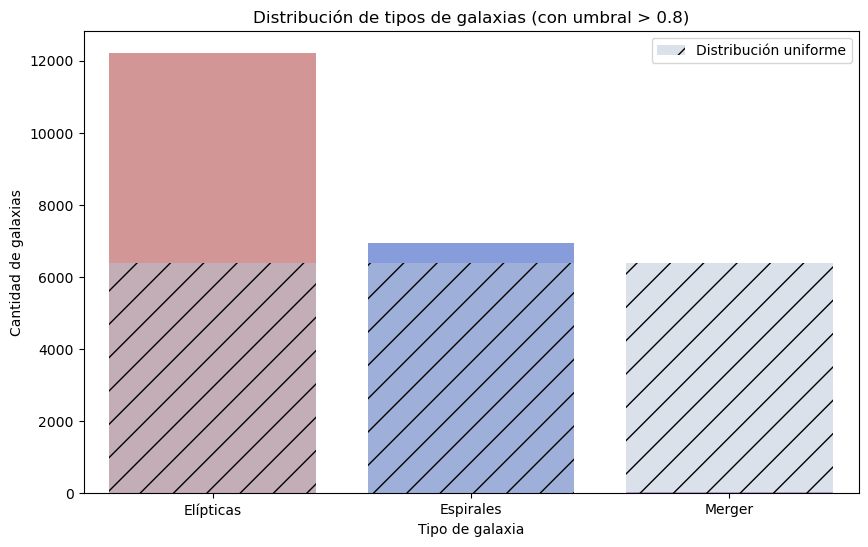

In [44]:
# TEST DE UNIFORMIDAD PARA TIPOS DE GALAXIAS
 
cantidad_elip = len(elip)
cantidad_esp = len(esp)
cantidad_mer = len(mer)
data = {
    'Tipo': ['Elípticas', 'Espirales', 'Merger'],
    'Cantidad': [cantidad_elip, cantidad_esp, cantidad_mer]
}
df_tipos = pd.DataFrame(data)
cant= sum(data['Cantidad'])

chi_norm=[]
grados_libertad=2 #cantidad de bines -1  
chi_critico=st.chi2.ppf((1-0.05),grados_libertad)
p_critico=0.05


esperado_uniforme = [cant/3, cant/3, cant/3]
chi2, p_value1 = st.chisquare(data['Cantidad'], esperado_uniforme)

print(" TEST CONTRA DISTRIBUCIÓN UNIFORME:")
print(f"   Observado: {data['Cantidad']}")
print(f"   Esperado:  {[int(x) for x in esperado_uniforme]}")
print(f"   Chi² = {chi2:.4f}, Chi critico = {chi_critico:.4f} ")
print(f"   p-value = {p_value1:.4f}")
print(f"   Grados de libertad = {grados_libertad}")
print('Usando como test estadístico al valor de p')
if p_value1 < p_critico:
    print("   RESULTADO: Rechazamos H₀ - La distribución NO es uniforme")
else:
    print("   RESULTADO: No rechazamos H₀ - La distribución podría ser uniforme")
print('Usando como test estadístico al chi²')
if chi2 >= chi_critico:
    print("   RESULTADO: Rechazamos H₀ - La distribución NO es uniforme")
else:
    print("   RESULTADO: No rechazamos H₀ - La distribución podría ser uniforme")

# Crear el gráfico con seaborn
plt.figure(figsize=(10, 6))
colors = [color_r, color_a, "#8732cd"]  # Rojo, azul, verde

# Crear el barplot
ax = sns.barplot(data=df_tipos, x='Tipo', y='Cantidad',palette=colors, alpha=0.7,hue='Tipo')
ax1 = sns.barplot(data=df_tipos, x='Tipo', y=esperado_uniforme,color='lightsteelblue',alpha=0.5, hatch='/',label='Distribución uniforme')
# Personalizar el gráfico
plt.ylabel('Cantidad de galaxias')
plt.xlabel('Tipo de galaxia')
plt.legend()
plt.title('Distribución de tipos de galaxias (con umbral > 0.8)')
plt.savefig('/mnt/sda2/astrometria/practico_3/informe/imagenes/morfologia.pdf',dpi=300,bbox_inches='tight')
plt.show()

/tmp/ipykernel_15057/57037441.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
/tmp/ipykernel_15057/57037441.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()
/tmp/ipykernel_15057/57037441.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend()


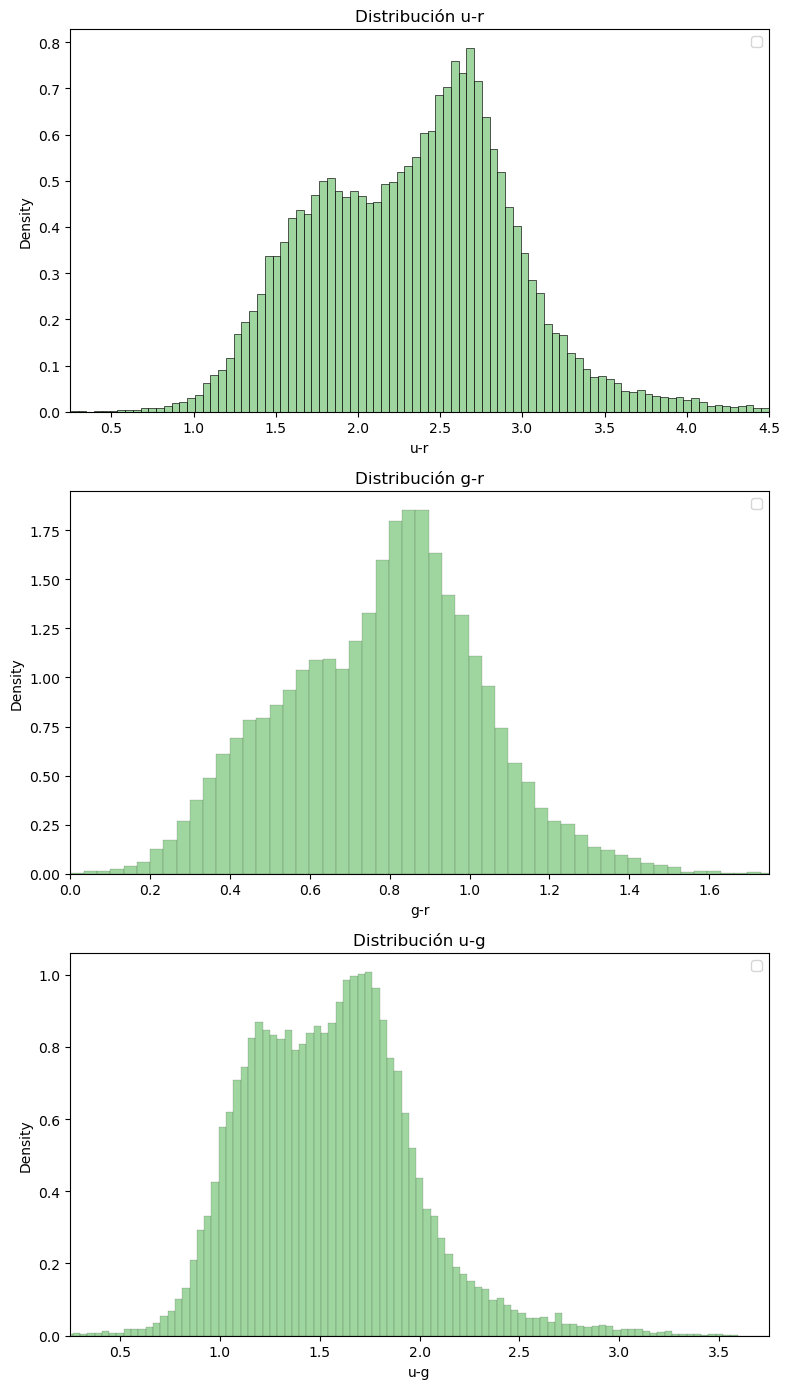

In [45]:
# Gráficos de Rojas y Azules en una sola figura vertical
fig, axes = plt.subplots(3, 1, figsize=(8, 14))

# u-r
sns.histplot((df['u'] - df['r']), bins='auto', alpha=0.75, stat='density', ax=axes[0])
axes[0].set_xlim(0.25, 4.5)
axes[0].set_xlabel('u-r')
axes[0].set_title('Distribución u-r')
axes[0].legend()

# g-r
sns.histplot((df['g'] - df['r']), bins='auto', alpha=0.75, stat='density', ax=axes[1])
axes[1].set_xlim(0, 1.75)
axes[1].set_xlabel('g-r')
axes[1].set_title('Distribución g-r')
axes[1].legend()

# u-g
sns.histplot((df['u'] - df['g']), bins='auto', alpha=0.75, stat='density', ax=axes[2])
axes[2].set_xlim(0.25, 3.75)
axes[2].set_xlabel('u-g')
axes[2].set_title('Distribución u-g')
axes[2].legend()

plt.tight_layout()
plt.savefig('/mnt/sda2/astrometria/practico_3/informe/imagenes/rojas_azules_vertical.pdf', dpi=300, bbox_inches='tight')
plt.show()

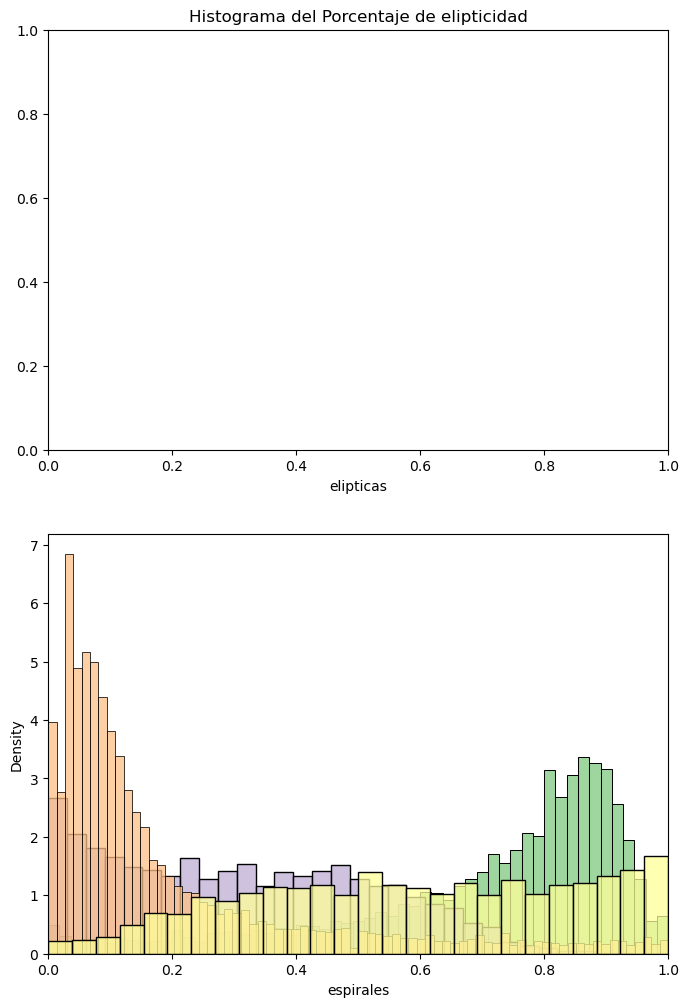

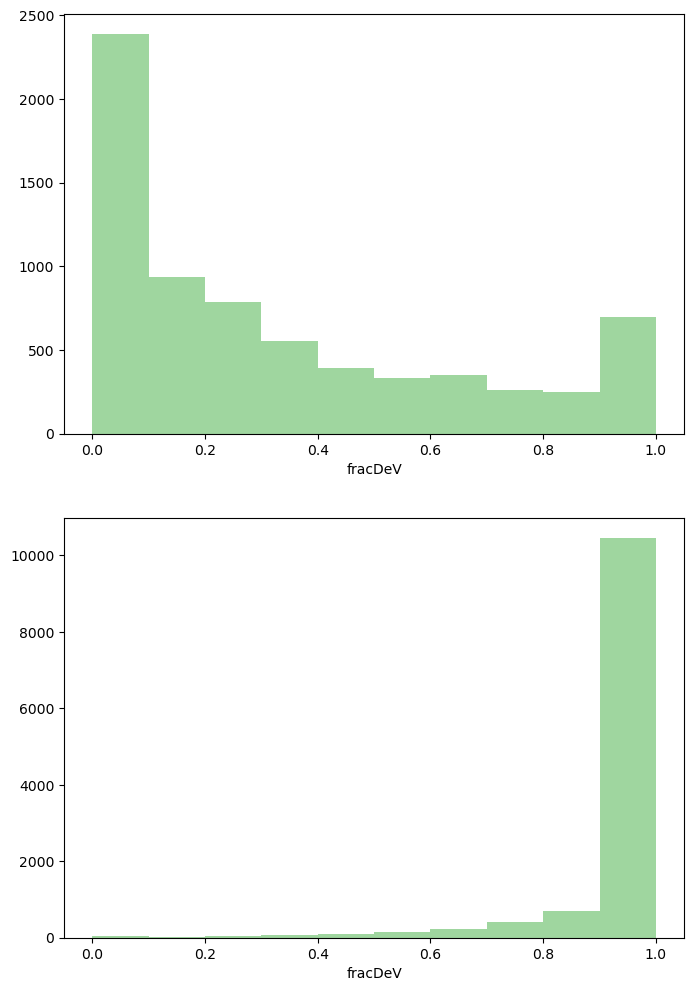

In [46]:
# BULGE Y DISCO
fig, axes = plt.subplots(2, 1,figsize=(8, 12))
sns.histplot(bulge['elip'],bins='auto',alpha=0.75,stat='density')
sns.histplot(disco['elip'],bins='auto',alpha=0.75,stat='density')
axes[0].set_xlim(0,1)
axes[0].set_xlabel('elipticas')
axes[0].set_title('Histograma del Porcentaje de elipticidad')
sns.histplot(bulge['esp'],bins='auto',alpha=0.75,stat='density')
sns.histplot(disco['esp'],bins='auto',alpha=0.75,stat='density')
axes[1].set_xlim(0,1)
axes[1].set_xlabel('espirales')
plt.show()

# ESPIRALES Y ELIPTICAS

fig, axes = plt.subplots(2, 1,figsize=(8, 12))

axes[0].hist(esp['fracDeV_r'],bins=10,alpha=0.75)

axes[0].set_xlabel('fracDeV')

axes[1].hist(elip['fracDeV_r'],bins=10,alpha=0.75)

axes[1].set_xlabel('fracDeV')
plt.show()

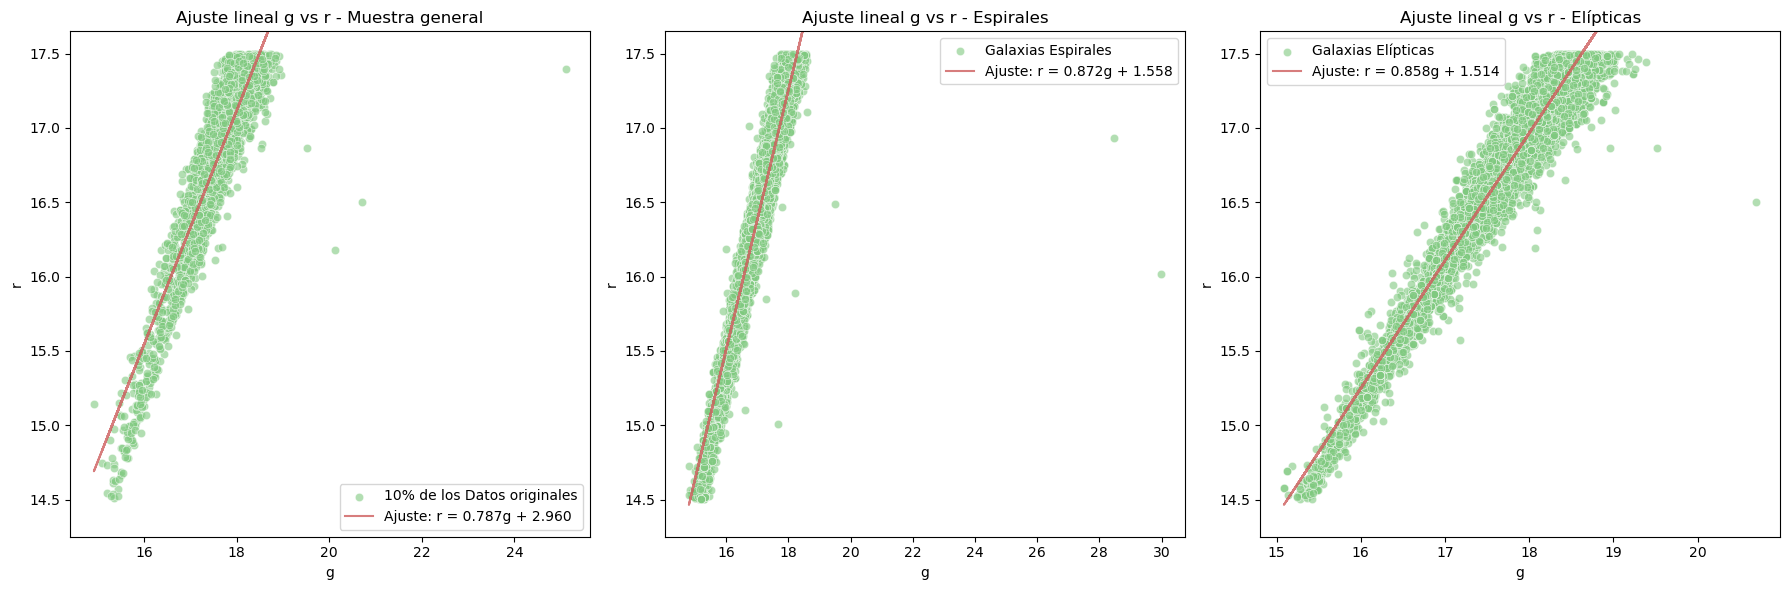

In [47]:
# AJUSTE LINEAL DE UNA MUESTRA

a_elip, b_elip = cuad_min(elip['g'], elip['r'])
y_elip = a_elip * elip['g'] + b_elip
a_esp, b_esp = cuad_min(esp['g'], esp['r'])
y_esp = a_esp * esp['g'] + b_esp

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Primer subplot - Muestra general
sns.scatterplot(x=muestra['g'], y=muestra['r'], alpha=0.6, label='10% de los Datos originales', ax=axes[0])
axes[0].plot(muestra['g'], y, color=color_r, alpha=0.8, label=f'Ajuste: r = {a:.3f}g + {b:.3f}')
axes[0].set_ylim(14.25, 17.65)
axes[0].set_xlabel('g')
axes[0].set_ylabel('r')
axes[0].legend()
axes[0].set_title('Ajuste lineal g vs r - Muestra general')

# Segundo subplot - Galaxias espirales
sns.scatterplot(x=esp['g'], y=esp['r'], alpha=0.6, label='Galaxias Espirales', ax=axes[1])
axes[1].plot(esp['g'], y_esp, color=color_r, alpha=0.8, label=f'Ajuste: r = {a_esp:.3f}g + {b_esp:.3f}')
axes[1].set_ylim(14.25, 17.65)
axes[1].set_xlabel('g')
axes[1].set_ylabel('r')
axes[1].legend()
axes[1].set_title('Ajuste lineal g vs r - Espirales')

# Tercer subplot - Galaxias elípticas
sns.scatterplot(x=elip['g'], y=elip['r'], alpha=0.6, label='Galaxias Elípticas', ax=axes[2])
axes[2].plot(elip['g'], y_elip, color=color_r, alpha=0.8, label=f'Ajuste: r = {a_elip:.3f}g + {b_elip:.3f}')
axes[2].set_ylim(14.25, 17.65)
axes[2].set_xlabel('g')
axes[2].set_ylabel('r')
axes[2].legend()
axes[2].set_title('Ajuste lineal g vs r - Elípticas')

plt.tight_layout()
plt.savefig('/mnt/sda2/astrometria/practico_3/informe/imagenes/ajustes_lineales_comparacion.pdf', dpi=300, bbox_inches='tight')
plt.show()

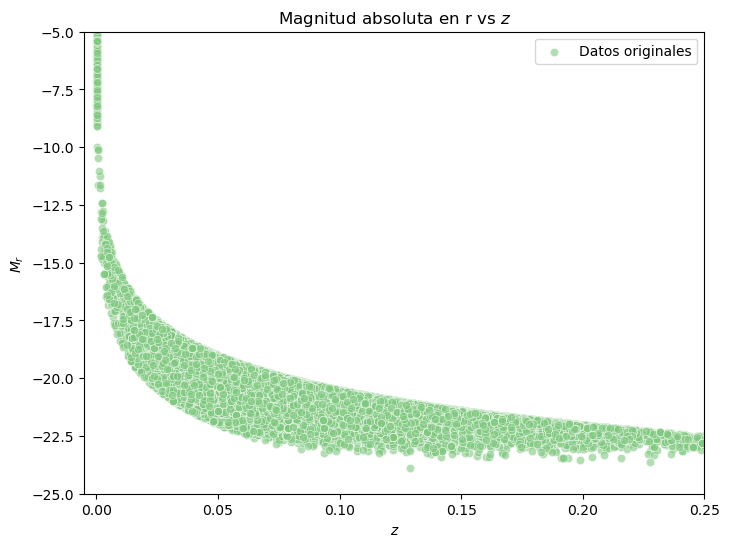

In [48]:
# MAGNITUD ABSOLUTA VS z
c=300000
H0=75
M_abs= df['r']-25-5*np.log10(c*df['z']/H0)


def f(x):
    f=a*np.log10(x+b)


plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['z'],y=M_abs, alpha=0.6, label='Datos originales')
#plt.plot(muestra['g'], y, color=color_r, alpha=0.8, label=f'Ajuste: r = {a:.3f}g + {b:.3f}')
plt.xlim(-0.005,0.25)
plt.ylim(-25,-5)
plt.xlabel('$z$')
plt.ylabel('$M_r$')
plt.legend()
plt.title('Magnitud absoluta en r vs $z$')
plt.savefig('/mnt/sda2/astrometria/practico_3/informe/imagenes/mabs.pdf',dpi=300,bbox_inches='tight')
plt.show()

Parámetros ajustados (a, b, c): [-2.78498846e+00 -2.19854520e-03 -2.52777442e+01]
Errores 1-sigma: [1.33560579e-01 1.29951917e-04 1.34624417e-01]
R² = 0.8785
Puntos usados: 100


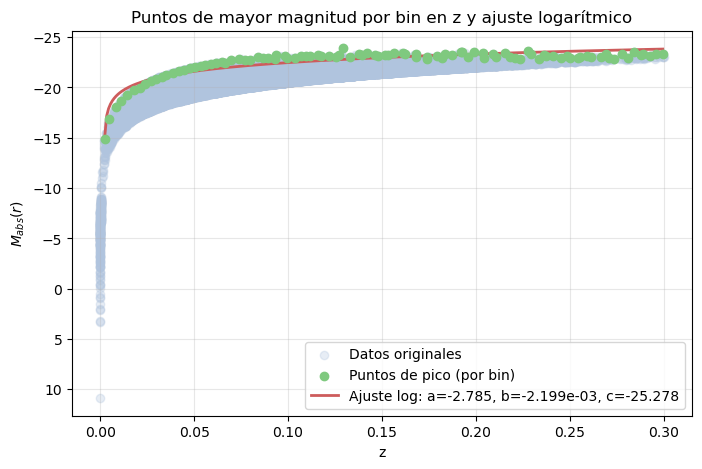

In [54]:

# Parámetros cosmológicos (recalculo localmente para evitar dependencias)
c_km_s = 300000.0
H0 = 75.0

# Recalculo magnitud absoluta (si ya existe, esto la sobrescribe con la misma definición)
M_abs = df['r'] - 25 - 5 * np.log10(c_km_s * df['z'] / H0)

# Filtrar z válidos (>0)
mask_z = df['z'] > 0
df_z = df[mask_z].copy()
df_z['M_abs'] = M_abs[mask_z]

# Número de bins (usa n_bins si existe, sino 20)

n_bins = 100

# Crear bines en z y asignar cada objeto a un bin
z_min, z_max = df_z['z'].min(), df_z['z'].max()
bins = np.linspace(z_min, z_max, n_bins + 1)
df_z['z_bin'] = pd.cut(df_z['z'], bins=bins, labels=False, include_lowest=True)

# Para cada bin, seleccionar el objeto con M_abs mínimo (más brillante)
idx_min = df_z.groupby('z_bin')['M_abs'].idxmin()
idx_min = idx_min.dropna().astype(int)
df_peaks = df_z.loc[idx_min].dropna(subset=['z','M_abs']).copy()

# Asegurar orden por z
df_peaks = df_peaks.sort_values('z')
z_peaks = df_peaks['z'].values
M_peaks = df_peaks['M_abs'].values

# Revisar que haya suficientes puntos para ajustar (>=3 parámetros)
if z_peaks.size < 3:
    raise RuntimeError("No hay suficientes puntos de pico para ajustar (se requieren >= 3).")

# Modelo logarítmico: f(z) = a * log10(z + b) + c
def log_model(z, a, b, c):
    return a * np.log10(z + b) + c

# Estimación inicial (ajustar si es necesario)
p0 = [-5.0, 1e-3, -20.0]


# Ajuste con bounds para evitar argumentos log negativos (b > -min(z_peaks))
b_min = max(-0.9 * z_peaks.min(), -0.9999)  # límite inferior razonable
bounds = ([-np.inf, b_min, -np.inf], [np.inf, np.inf, np.inf])

popt, pcov = opt.curve_fit(log_model, z_peaks, M_peaks, p0=p0, bounds=bounds, maxfev=10000)
perr = np.sqrt(np.diag(pcov))

# Métrica de bondad (R^2)
residuals = M_peaks - log_model(z_peaks, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((M_peaks - M_peaks.mean())**2)
r_squared = 1 - ss_res / ss_tot

# Imprimir resultados
print("Parámetros ajustados (a, b, c):", popt)
print("Errores 1-sigma:", perr)
print(f"R² = {r_squared:.4f}")
print(f"Puntos usados: {len(z_peaks)}")

# Graficar puntos y ajuste
z_fit = np.linspace(z_peaks.min(), z_peaks.max(), 300)
M_fit = log_model(z_fit, *popt)

plt.figure(figsize=(8,5))
plt.scatter(x=df_z['z'], y=df_z['M_abs'], alpha=0.3,color='lightsteelblue', label='Datos originales', zorder=1)
plt.scatter(df_peaks['z'], df_peaks['M_abs'], color='C0', label='Puntos de pico (por bin)', zorder=3)
plt.plot(z_fit, M_fit, color=color_r, lw=2, label=f'Ajuste log: a={popt[0]:.3f}, b={popt[1]:.3e}, c={popt[2]:.3f}')
plt.gca().invert_yaxis()  # en magnitudes es habitual invertir el eje
plt.xlabel('z')
plt.ylabel('$M_{abs} (r)$')
plt.title('Puntos de mayor magnitud por bin en z y ajuste logarítmico')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('/mnt/sda2/astrometria/practico_3/informe/imagenes/mabs_vs_z_ajuste_log.pdf', dpi=300, bbox_inches='tight')
plt.show()

Parámetros ajustados (a, b, c): [-4.96862864e+00  7.97266121e-10 -2.54998982e+01]
Errores 1-sigma: [9.79941505e-03 1.86760871e-09 1.00340820e-02]
R² = 0.9999
Puntos usados: 100


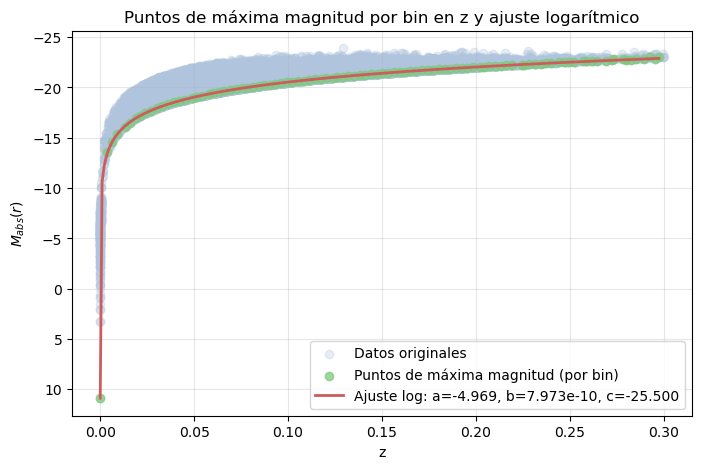

In [58]:
# Parámetros cosmológicos (recalculo localmente para evitar dependencias)
c_km_s = 300000.0
H0 = 75.0

# Recalculo magnitud absoluta (si ya existe, esto la sobrescribe con la misma definición)
M_abs = df['r'] - 25 - 5 * np.log10(c_km_s * df['z'] / H0)

# Filtrar z válidos (>0)
mask_z = df['z'] > 0
df_z = df[mask_z].copy()
df_z['M_abs'] = M_abs[mask_z]

# Número de bins (usa n_bins si existe, sino 20)
n_bins = 100

# Crear bines en z y asignar cada objeto a un bin
z_min, z_max = df_z['z'].min(), df_z['z'].max()
bins = np.linspace(z_min, z_max, n_bins + 1)
df_z['z_bin'] = pd.cut(df_z['z'], bins=bins, labels=False, include_lowest=True)

# Para cada bin, seleccionar el objeto con M_abs máximo (menos brillante)
idx_max = df_z.groupby('z_bin')['M_abs'].idxmax()
idx_max = idx_max.dropna().astype(int)
df_peaks = df_z.loc[idx_max].dropna(subset=['z','M_abs']).copy()

# Asegurar orden por z
df_peaks = df_peaks.sort_values('z')
z_peaks = df_peaks['z'].values
M_peaks = df_peaks['M_abs'].values

# Revisar que haya suficientes puntos para ajustar (>=3 parámetros)
if z_peaks.size < 3:
    raise RuntimeError("No hay suficientes puntos de pico para ajustar (se requieren >= 3).")

# Modelo logarítmico: f(z) = a * log10(z + b) + c
def log_model(z, a, b, c):
    return a * np.log10(z + b) + c

# Estimación inicial (ajustar si es necesario para valores máximos)
p0 = [5.0, 1e-3, -15.0]  # Cambiado: a positivo para pendiente creciente

# Ajuste con bounds para evitar argumentos log negativos (b > -min(z_peaks))
b_min = max(-0.9 * z_peaks.min(), -0.9999)  # límite inferior razonable
bounds = ([-np.inf, b_min, -np.inf], [np.inf, np.inf, np.inf])

popt, pcov = opt.curve_fit(log_model, z_peaks, M_peaks, p0=p0, bounds=bounds, maxfev=10000)
perr = np.sqrt(np.diag(pcov))

# Métrica de bondad (R^2)
residuals = M_peaks - log_model(z_peaks, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((M_peaks - M_peaks.mean())**2)
r_squared = 1 - ss_res / ss_tot

# Imprimir resultados
print("Parámetros ajustados (a, b, c):", popt)
print("Errores 1-sigma:", perr)
print(f"R² = {r_squared:.4f}")
print(f"Puntos usados: {len(z_peaks)}")

# Graficar puntos y ajuste
z_fit = np.linspace(z_peaks.min(), z_peaks.max(), 300)
M_fit = log_model(z_fit, *popt)

plt.figure(figsize=(8,5))
plt.scatter(x=df_z['z'], y=df_z['M_abs'], alpha=0.3,color='lightsteelblue', label='Datos originales', zorder=1)
plt.scatter(df_peaks['z'], df_peaks['M_abs'], alpha=0.75, label='Puntos de máxima magnitud (por bin)', zorder=2)
plt.plot(z_fit, M_fit, color=color_r, lw=2, label=f'Ajuste log: a={popt[0]:.3f}, b={popt[1]:.3e}, c={popt[2]:.3f}')
plt.gca().invert_yaxis()  # en magnitudes es habitual invertir el eje
plt.xlabel('z')
plt.ylabel('$M_{abs} (r)$')
plt.title('Puntos de máxima magnitud por bin en z y ajuste logarítmico')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('/mnt/sda2/astrometria/practico_3/informe/imagenes/mabs_vs_z_ajuste_log_max.pdf', dpi=300, bbox_inches='tight')
plt.show()